<a href="https://colab.research.google.com/github/AshiishKarhade/Image-Captioning/blob/master/Image_Caption_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip
print("DONE!")

In [0]:
!rm Flickr8k_Dataset.zip
!rm Flickr8k_text.zip

In [0]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

In [0]:
token = 'Flickr8k.token.txt'

In [0]:
captions = open(token, 'r').read().strip().split('\n')

## Part 1

In [0]:
captions[:10]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .']

In [0]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [0]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
images = 'Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

In [0]:
img[:5]

['Flicker8k_Dataset/3331797838_b3e33dbe17.jpg',
 'Flicker8k_Dataset/3532782283_341f0381a3.jpg',
 'Flicker8k_Dataset/426805536_d1d5e68c17.jpg',
 'Flicker8k_Dataset/3338217927_3c5cf3f7c6.jpg',
 'Flicker8k_Dataset/2140747429_62cfd89ae9.jpg']

In [0]:
train_images_file = 'Flickr_8k.trainImages.txt'

In [0]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [0]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [0]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [0]:
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [0]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

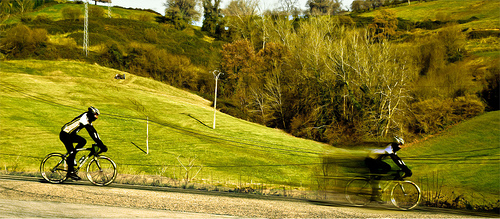

In [0]:
Image.open(train_img[0])

In [0]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [0]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


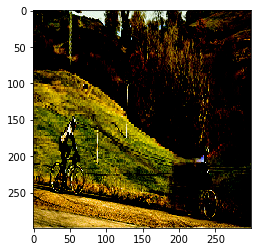

In [0]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [0]:
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 3s 0us/step


In [0]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [0]:
tryi = model_new.predict(preprocess(train_img[0]))

In [0]:
tryi.shape

(1, 2048)

In [0]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)


100%|██████████| 6000/6000 [02:14<00:00, 44.87it/s]


In [0]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [0]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [0]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [0]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [00:22<00:00, 45.01it/s]


In [0]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [0]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [0]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [0]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [0]:
# calculate unique words in disctionARY
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
words = [i.split() for i in caps]

unique = []
for i in words:
    unique.extend(i)

unique = list(set(unique))

In [0]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d) 

In [0]:
unique = pickle.load(open('unique.p', 'rb'))

In [0]:
# mapping the unique words to indices and vice-versa

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}

word2idx['<start>']

5569

In [0]:
idx2word = {index:val for index, val in enumerate(unique)}

idx2word[2214]

'poof'

In [0]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
len(unique), max_len
vocab_size = len(unique)

In [0]:
# Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [0]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [0]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [0]:

c = [i for i in df['captions']]
len(c)

30000

In [0]:
imgs = [i for i in df['image_id']]

In [0]:
a = c[-1]
a, imgs[-1]

('<start> Three white puppies are being washed in a bathtub with hand held shower . <end>',
 '3656030945_fa003bd696.jpg')

In [0]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 5569
Three => 6637
white => 1092
puppies => 5688
are => 8190
being => 4968
washed => 2040
in => 1562
a => 7977
bathtub => 7520
with => 3804
hand => 225
held => 7017
shower => 2628
. => 2926
<end> => 6627


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [0]:
samples_per_epoch

383454

GENERATOR

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 300

In [0]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

NameError: ignored

In [0]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [0]:
from keras.models import Model
from keras.layers import concatenate

merged_layers = concatenate([image_model.output, caption_model.output])

x = Bidirectional(LSTM(256, return_sequences=False))(merged_layers)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)


final_model = Model([image_model.input, caption_model.input], [out])

final_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dense_1_input[0][0]              
____________________________________________________________________________________________

In [0]:
final_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      2476800     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      dense_1_input[0][0]              
____________________________________________________________________________________________

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=6, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, steps_per_epoch=383454, epochs=6)`
  """Entry point for launching an IPython kernel.




Epoch 1/6


In [0]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=4, 
                          verbose=2)

In [0]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

# PART #2

In [0]:
filename = 'Flickr8k.token.txt'

file = open(filename, 'r')
doc = file.read()

In [0]:
doc[:1000]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [0]:
# Converting above format to dictionary format so that the image_name (without extension) becomes key and their corresponding captions becomes values

descriptions = dict()

for line in doc.split('\n'):
  token = line.split()
  try:
    image_id, image_desc = token[0], token[1:]
  except:
    image_id, image_desc = "",""

  #extract filename from image_id
  image_id = image_id.split('.')[0]

  #making image_desc list back to string
  image_desc = ' '.join(image_desc)

  if image_id not in descriptions:
    descriptions[image_id] = list()
  descriptions[image_id].append(image_desc)

In [0]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
# prepare translation table for removing punctuation
import string
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

In [0]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [0]:
with open('descriptions.txt', 'w') as f:
    f.write(str(descriptions))

In [0]:
# Create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus) in the data set

vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
#We write all these captions along with their image names in a new file namely, “descriptions.txt” and save it on the disk.

# But first, take the vocab into considerations the words that occur atleast 5 times

# Create a list of all the training captions
all_train_captions = []
for key, val in descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 5
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print("preprocessed words {}".format(len(vocab)))

preprocessed words 2981


In [0]:
# Traininet set images names

def open_doc(filename):
  with open(filename, 'r') as f:
    doc = f.read()
  return doc

filename = 'Flickr_8k.trainImages.txt'
doc = open_doc(filename)
train = list()
for line in doc.split('\n'):
    identifier = line.split('.')[0]
    train.append(identifier)
print("Dataset: {}".format(len(train)))

Dataset: 6001


In [0]:
train_descriptions = dict()

doc = open_doc('descriptions.txt')
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # skip images not in the set
    if image_id in train:
        if image_id not in descriptions:
            train_descriptions[image_id] = list()
        
        # wrap description in tokens
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        
        # store
        train_descriptions[image_id].append(desc)

        print('Descriptions: train = {}'.format(len(train_descriptions)))

## Preparing images

In [0]:
from keras import Model
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')

# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)














96116736/96112376 [==============================] - 3s 0us/step


In [0]:
images = 'Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

In [0]:
train_images_file = 'Flickr_8k.trainImages.txt'

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

# Getting the training images from all the images
train_img = split_data(train_images)
print(len(train_img))

"""
val_images_file = 'Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)
"""


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

0


In [0]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)


with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 




0it [00:00, ?it/s]


In [0]:
encoding_train = pickle.load(open('encoded_train_images.pkl', 'rb'))

In [0]:
test_images_file = 'Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

0

In [0]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

0it [00:00, ?it/s]


In [0]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

encoding_test = pickle.load(open('encoded_test_images.pkl', 'rb'))

In [0]:
# Mapping word to index to make vector of numbers for captions using our vocabulary of distinct words

ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
# Calculating Maximum length of caption

# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

# Calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 32


In [0]:
# Image DATA Generatorrs

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
          try:
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
          except:
            pass
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [0]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2020-02-16 17:31:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.00MB/s    in 6m 27s  

2020-02-16 17:38:14 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
!unzip glove.6B.zip
!rm glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
# Load Glove vectors
import os

embeddings_index = {} 

f = open(('glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
embedding_dim = 200
vocab_size = len(vocab) + 1
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

## MODEL

In [0]:
from keras.layers import Input, Dropout, Add, concatenate

# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      596400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch)
photos = encoding_train

model.optimizer.lr = 0.001
model.fit_generator(data_generator(descriptions, photos, wordtoix, max_length=32,num_photos_per_batch=3), steps_per_epoch=2000, nb_epoch=20, verbose=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=2000, verbose=2, epochs=20)`
  after removing the cwd from sys.path.




Epoch 1/20


ValueError: ignored

In [0]:
#model.optimizer.lr = 0.0001
model.fit_generator(data_generator_2(batch_size=128), steps_per_epoch=2995, nb_epoch=10, verbose=2)

# Part 3

In [4]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [7]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [14]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [0]:
# Below path contains all the images
images = 'Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = 'Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = 'Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [19]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 1s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [24]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 269.21533393859863


In [0]:
# Save the bottleneck train features to disk
import pickle

with open("encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [29]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 43.68610739707947


In [0]:
# Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [31]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [32]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [33]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [35]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [36]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [38]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

!unzip glove.6B.zip
!rm glove.6B.zip

--2020-02-17 14:55:22--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.15MB/s    in 6m 27s  

2020-02-17 15:01:49 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [39]:
# Load Glove vectors

embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [41]:
embedding_matrix.shape

(1652, 200)

In [42]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [44]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [52]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 203s 102ms/step - loss: 3.1971 - acc: 0.3139
Epoch 1/1
2000/2000 [==============================] - 202s 101ms/step - loss: 3.0667 - acc: 0.3249
Epoch 1/1
2000/2000 [==============================] - 199s 100ms/step - loss: 2.9707 - acc: 0.3339
Epoch 1/1
2000/2000 [==============================] - 198s 99ms/step - loss: 2.8977 - acc: 0.3412
Epoch 1/1
2000/2000 [==============================] - 199s 99ms/step - loss: 2.8405 - acc: 0.3453
Epoch 1/1
2000/2000 [==============================] - 203s 101ms/step - loss: 2.7944 - acc: 0.3500
Epoch 1/1
2000/2000 [==============================] - 202s 101ms/step - loss: 2.7541 - acc: 0.3544
Epoch 1/1
2000/2000 [==============================] - 203s 101ms/step - loss: 2.7208 - acc: 0.3580
Epoch 1/1
2000/2000 [==============================] - 202s 101ms/step - loss: 2.6892 - acc: 0.3617
Epoch 1/1
2000/2000 [==============================] - 202s 101ms/step - loss: 2.6663 - acc: 0.3639


In [53]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 201s 100ms/step - loss: 2.6400 - acc: 0.3670
Epoch 1/1
2000/2000 [==============================] - 201s 100ms/step - loss: 2.6221 - acc: 0.3685
Epoch 1/1
2000/2000 [==============================] - 199s 100ms/step - loss: 2.6019 - acc: 0.3705
Epoch 1/1
2000/2000 [==============================] - 200s 100ms/step - loss: 2.5847 - acc: 0.3731
Epoch 1/1
2000/2000 [==============================] - 198s 99ms/step - loss: 2.5718 - acc: 0.3745
Epoch 1/1
2000/2000 [==============================] - 199s 99ms/step - loss: 2.5588 - acc: 0.3761
Epoch 1/1
2000/2000 [==============================] - 201s 100ms/step - loss: 2.5461 - acc: 0.3768
Epoch 1/1
2000/2000 [==============================] - 200s 100ms/step - loss: 2.5357 - acc: 0.3781
Epoch 1/1
2000/2000 [==============================] - 199s 100ms/step - loss: 2.5229 - acc: 0.3799
Epoch 1/1
2000/2000 [==============================] - 200s 100ms/step - loss: 2.5149 - acc: 0.3808


In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [55]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.4672 - acc: 0.3892
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.4465 - acc: 0.3920
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.4384 - acc: 0.3924
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.4294 - acc: 0.3939
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 2.4232 - acc: 0.3947
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.4093 - acc: 0.3954
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 2.4020 - acc: 0.3975
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 2.3955 - acc: 0.3985
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 2.3882 - acc: 0.4001
Epoch 1/1
1000/1000 [==============================] - 108s 108ms/step - loss: 2.3797 - acc: 0.4004


In [0]:
model.save_weights('model_30.h5')

In [0]:
model.load_weights('model_30.h5')

In [0]:
images = 'Flicker8k_Dataset/'

with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

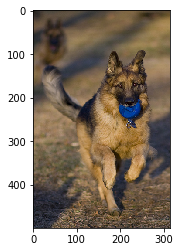

Greedy: german shepherd dog is running through the grass


In [64]:
z=108
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))